# BigQuery Churn Analysis

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



# Functions

In [2]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

# EDA

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/churn.csv")
df

,customer_id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,932aff1e-186f-418c-8716-28bba167c384,NY,86,area_code_510,False,False,0,70.7,125,12.02,...,113,17.94,174.6,107,7.86,0.0,0,0.00,2,False
1,143a0b05-b95a-4d00-ad2a-9c1b18234c29,VT,165,area_code_510,False,False,0,242.9,126,41.29,...,65,17.83,228.4,126,10.28,0.0,0,0.00,1,False
2,45debf35-7e4d-42da-ba4e-d737a8997e16,KS,70,area_code_415,False,False,0,222.8,114,37.88,...,113,18.35,223.5,122,10.06,0.0,0,0.00,1,False
3,76b4b68f-1113-4411-88ad-de38b482e9fb,NM,158,area_code_408,False,False,0,172.4,114,29.31,...,69,21.81,235.3,104,10.59,0.0,0,0.00,2,False
4,6ee9cecd-1a09-4f4a-937e-aa848c392bed,ND,101,area_code_415,False,False,0,217.7,118,37.01,...,128,19.69,185.3,128,8.34,0.0,0,0.00,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,e1db5067-6484-4a5d-b68d-ab869fff027d,UT,36,area_code_415,False,True,16,149.4,111,25.40,...,113,11.20,132.7,87,5.97,6.7,2,1.81,0,False
4246,99ad8c1e-c90b-44d5-ad36-d4d87aae0d85,MN,24,area_code_510,False,True,25,164.9,110,28.03,...,105,17.79,231.2,55,10.40,6.7,9,1.81,1,False
4247,b2287275-f563-40ae-ad9c-06844ca539f4,DE,97,area_code_415,False,True,32,183.4,94,31.18,...,120,22.87,203.5,38,9.16,6.7,4,1.81,5,False
4248,9908263a-a9c9-48f5-9c26-ca7cc9bd5917,IN,81,area_code_408,False,True,46,168.3,124,28.61,...,103,23.03,222.5,98,10.01,6.7,2,1.81,4,False


In [4]:
df["area_code"].value_counts()

area_code_415    2108
area_code_408    1086
area_code_510    1056
Name: area_code, dtype: int64

In [5]:
len(df["state"].unique())

51

In [6]:
df.drop(["state", "customer_id"],axis=1, inplace=True)

# Check For Nulls And Dupes

In [7]:
check_for_nulls_dupes(df)

The amount of Null Values: account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64
The amount of Duplicated Values 0


# Check Class Imbalance

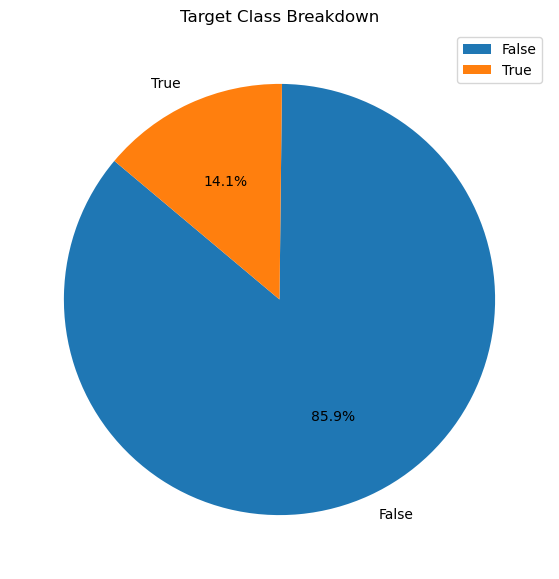

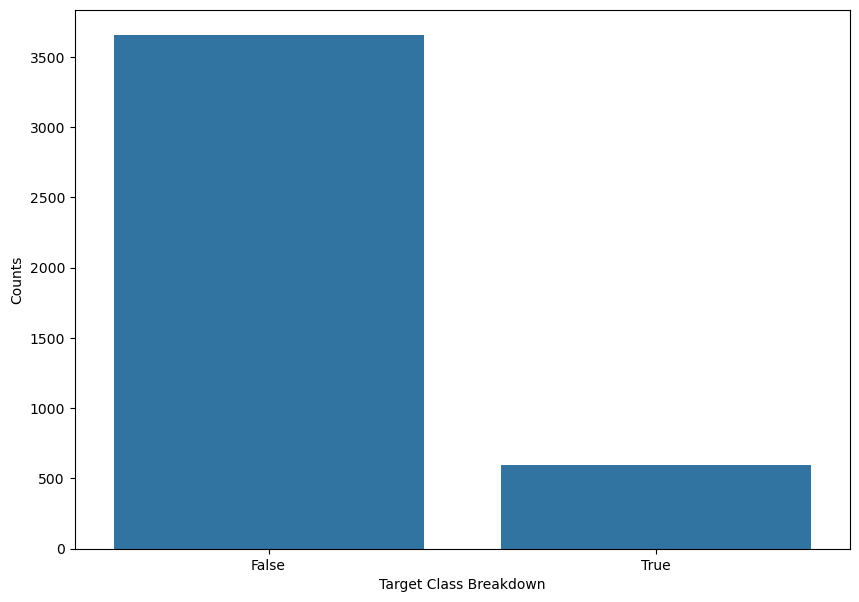

In [8]:
check_class_imbalance(df["churn"])

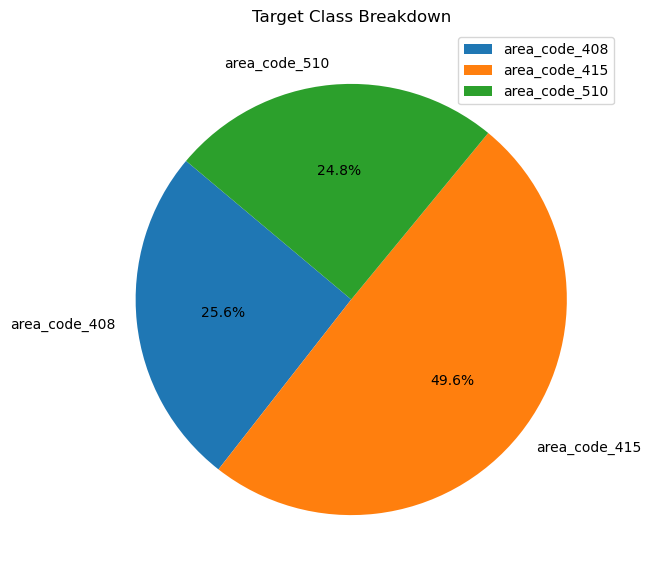

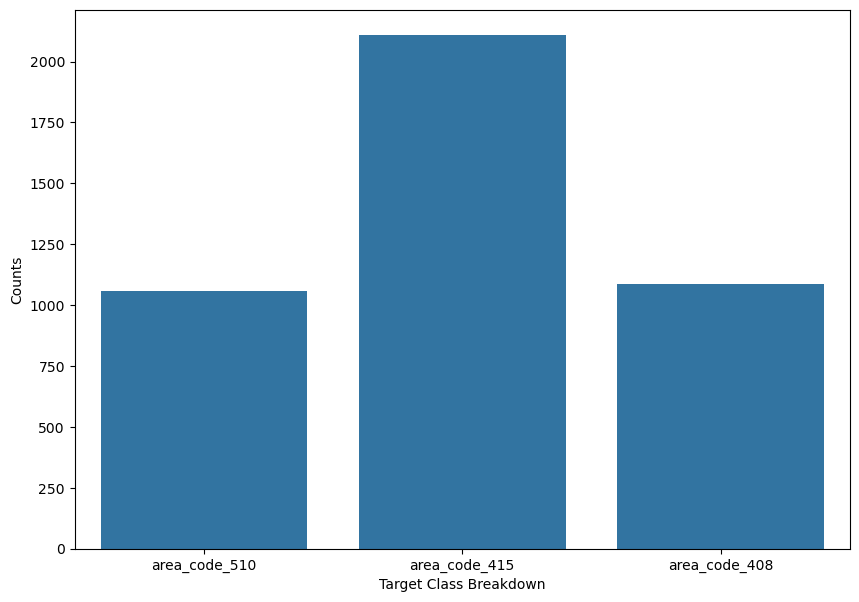

In [9]:
check_class_imbalance(df["area_code"])

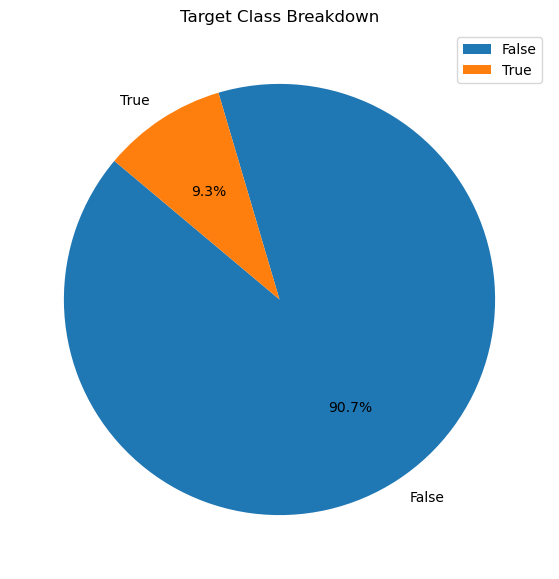

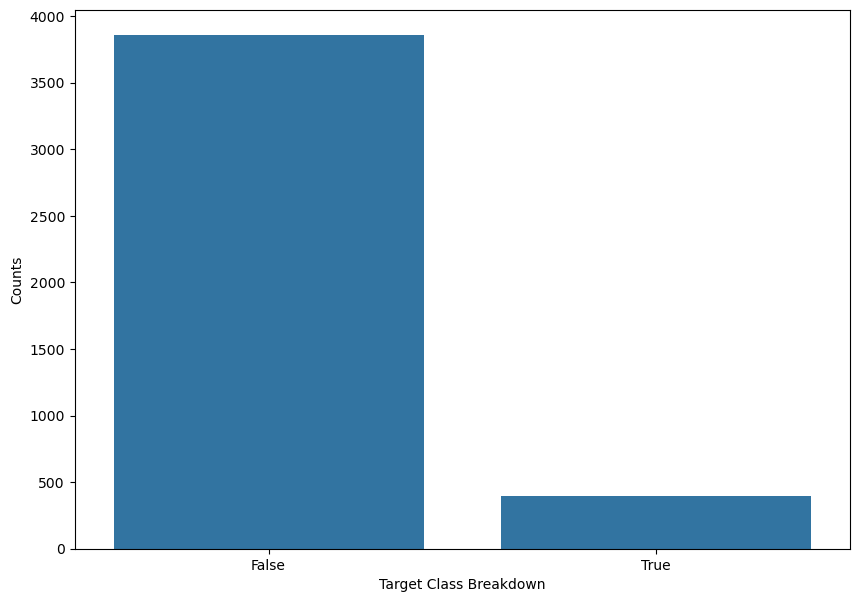

In [10]:
check_class_imbalance(df["international_plan"])

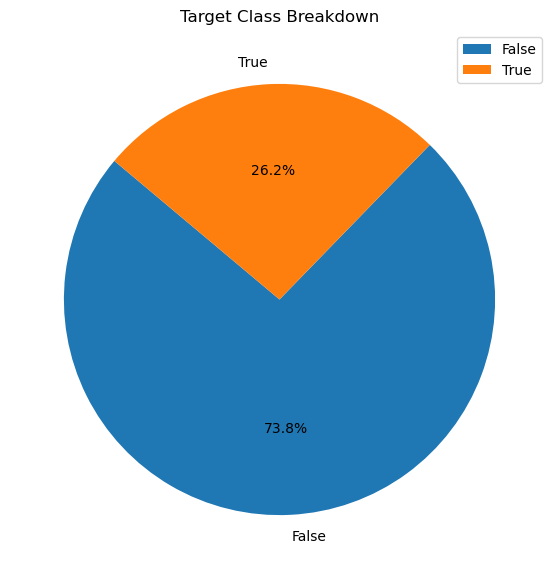

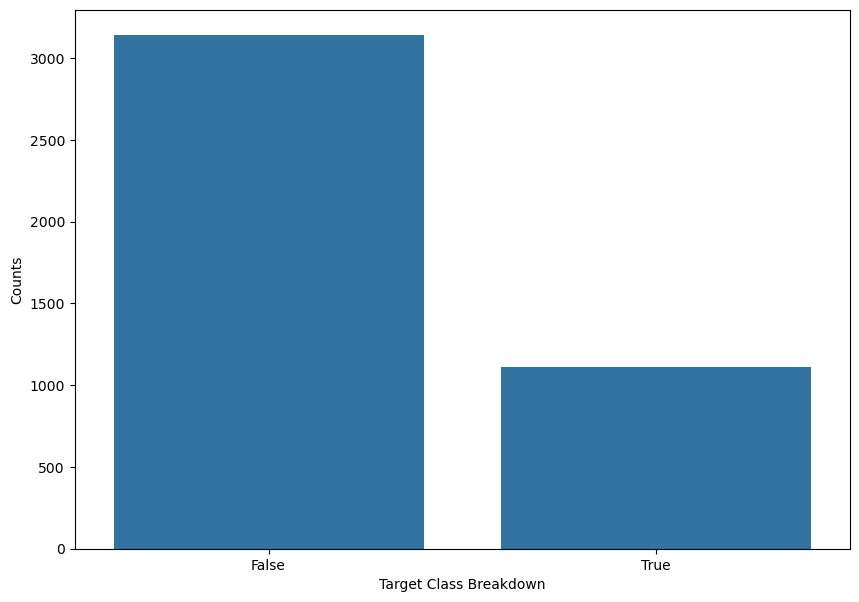

In [11]:
check_class_imbalance(df["voice_mail_plan"])

# Separate Categorical and Numerical Variables

In [12]:
categorical_types = df.select_dtypes(include="object")
numerical_types = df.select_dtypes(exclude="object")

# Visuals

<AxesSubplot:>

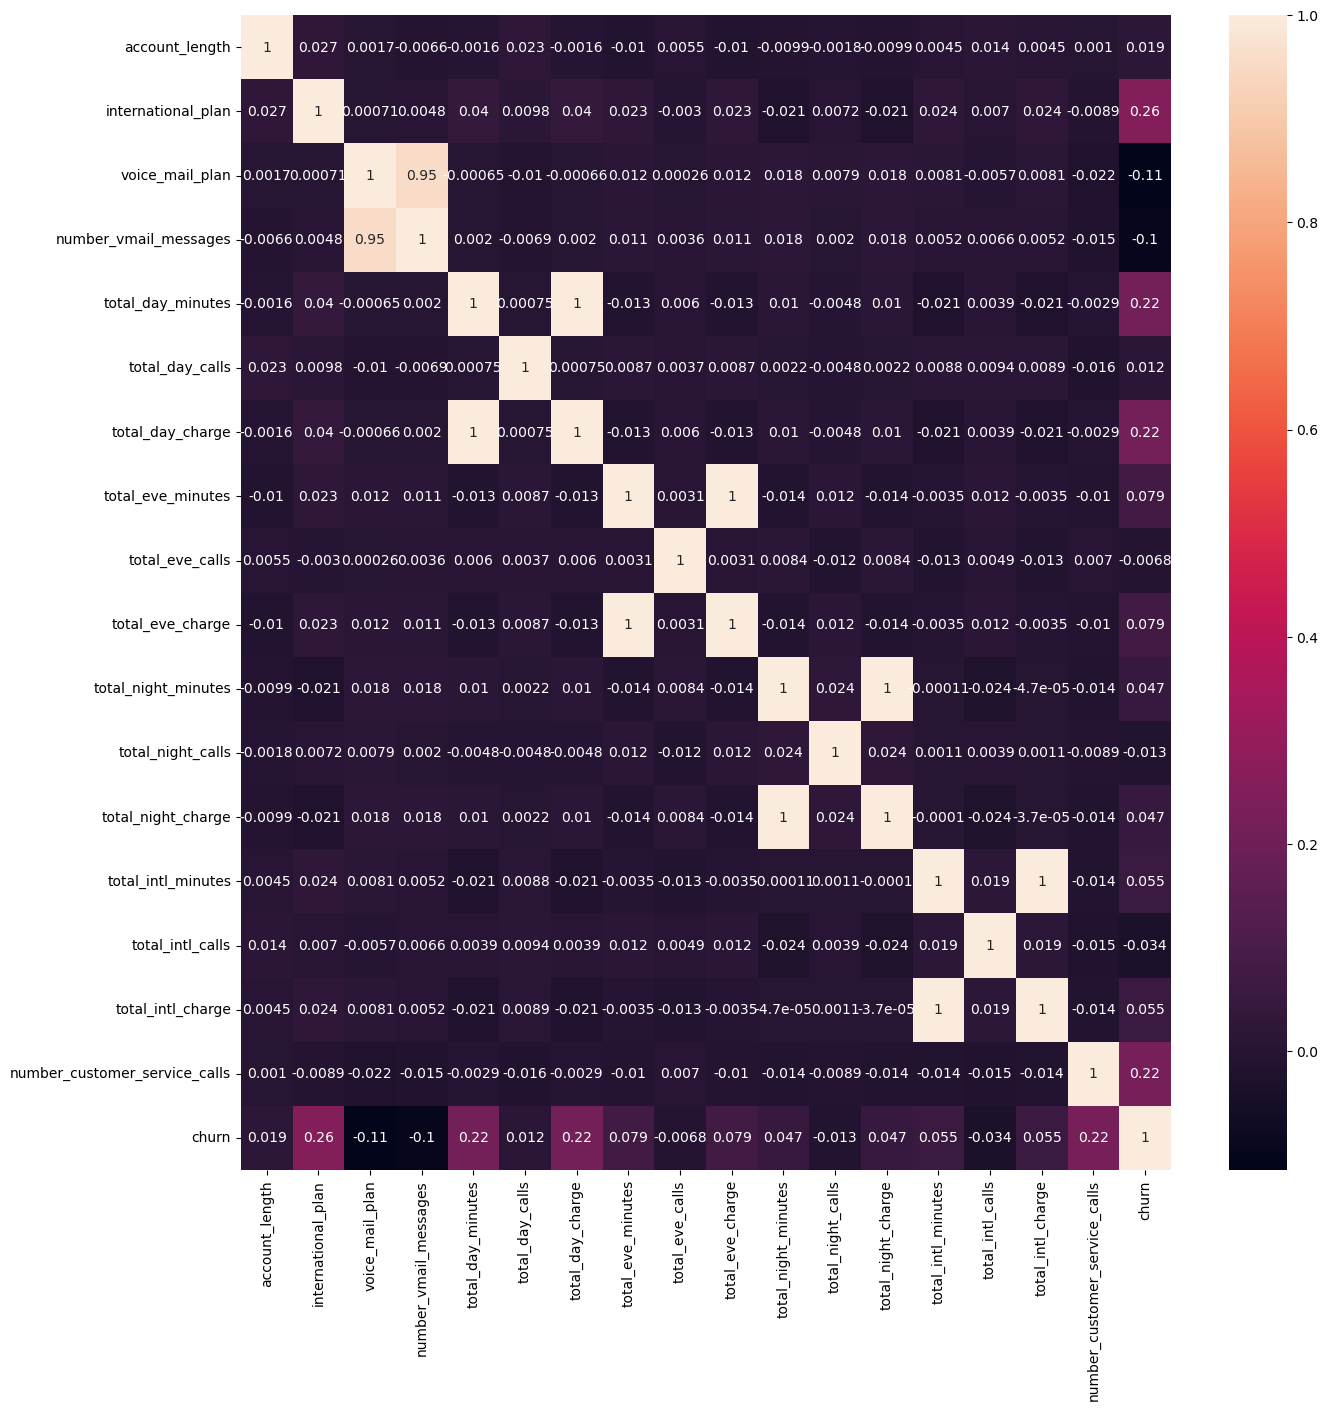

In [13]:
plt.figure(figsize=(15, 15))
relations = numerical_types.corr()
sns.heatmap(data=relations, annot=True)

# Histogram And Box Plots

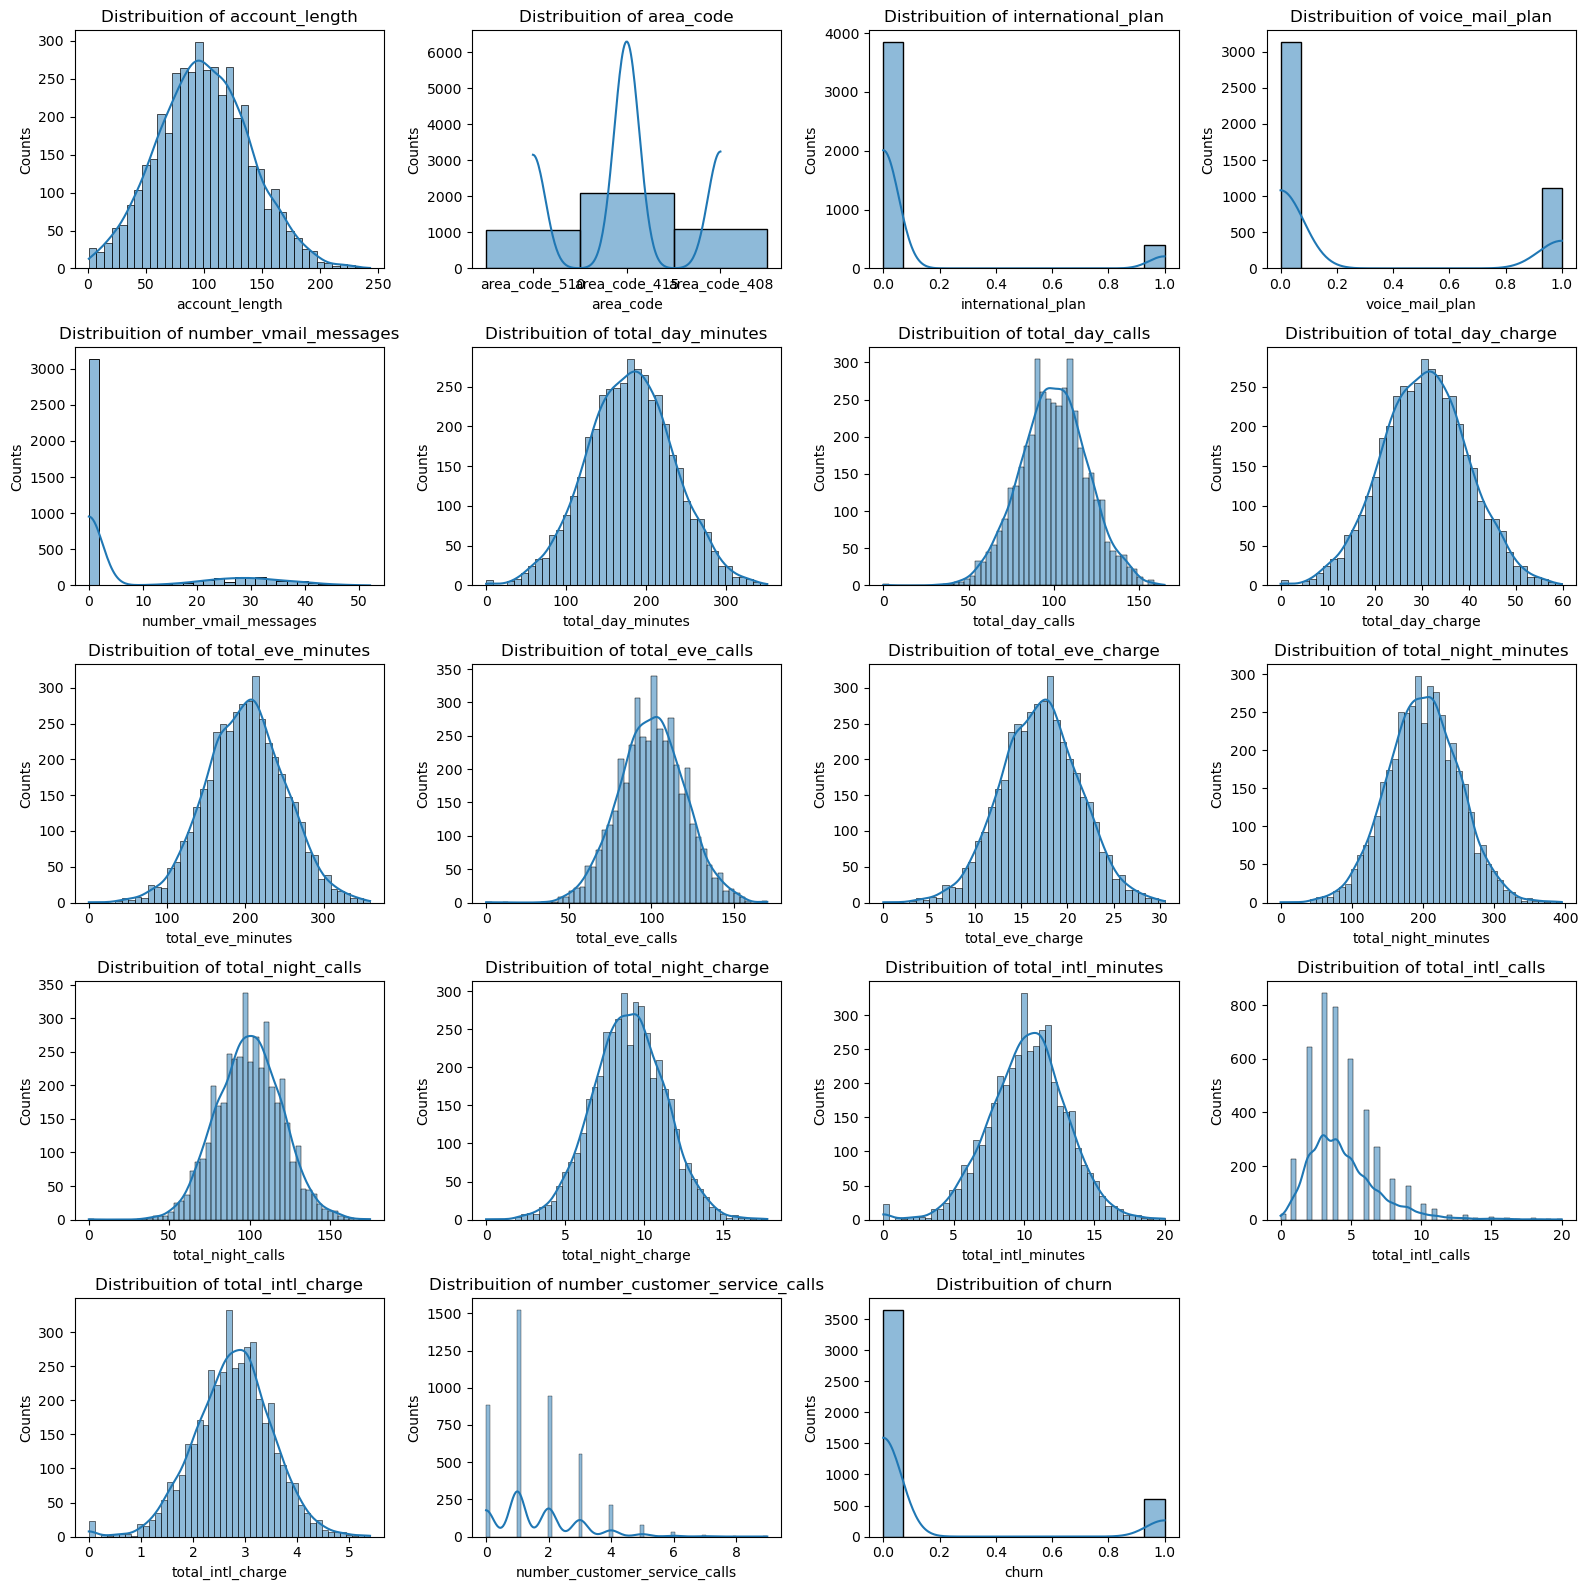

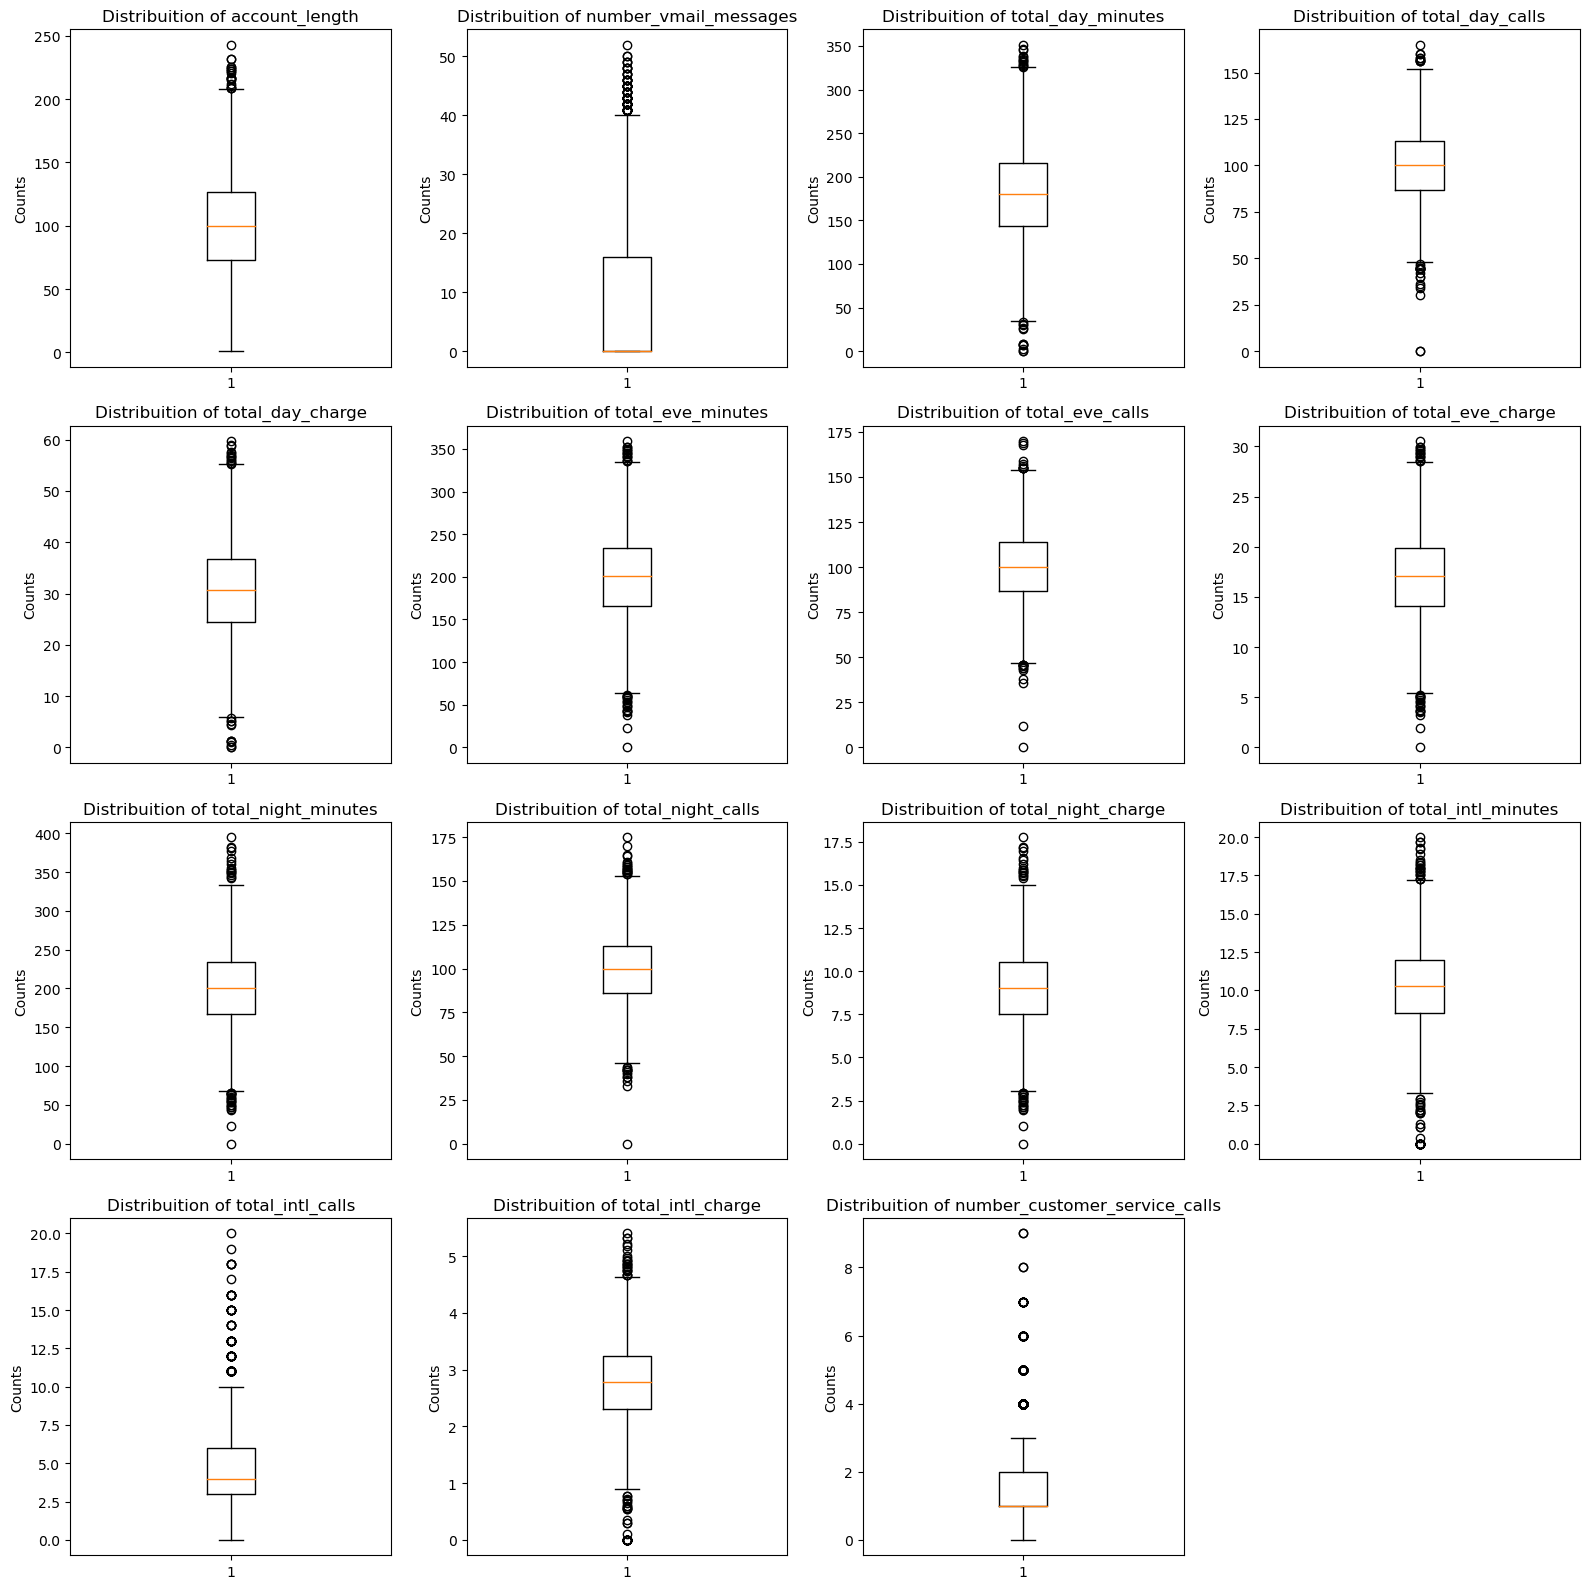

In [18]:
plot_distribution(df, "hist")
plot_distribution(df.select_dtypes(exclude=["object", "bool"]), "box")

In [16]:
numerical_types

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,86,False,False,0,70.7,125,12.02,211.0,113,17.94,174.6,107,7.86,0.0,0,0.00,2,False
1,165,False,False,0,242.9,126,41.29,209.8,65,17.83,228.4,126,10.28,0.0,0,0.00,1,False
2,70,False,False,0,222.8,114,37.88,215.9,113,18.35,223.5,122,10.06,0.0,0,0.00,1,False
3,158,False,False,0,172.4,114,29.31,256.6,69,21.81,235.3,104,10.59,0.0,0,0.00,2,False
4,101,False,False,0,217.7,118,37.01,231.7,128,19.69,185.3,128,8.34,0.0,0,0.00,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,36,False,True,16,149.4,111,25.40,131.8,113,11.20,132.7,87,5.97,6.7,2,1.81,0,False
4246,24,False,True,25,164.9,110,28.03,209.3,105,17.79,231.2,55,10.40,6.7,9,1.81,1,False
4247,97,False,True,32,183.4,94,31.18,269.1,120,22.87,203.5,38,9.16,6.7,4,1.81,5,False
4248,81,False,True,46,168.3,124,28.61,270.9,103,23.03,222.5,98,10.01,6.7,2,1.81,4,False
